# 用PCA实战人脸识别
https://www.jianshu.com/p/a53f9d847c0d

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()
X = faces.data
y = faces.target

要用PCA降维，首先要把图像Flat成一维向量。sklearn中的这个数据集已经处理好了，观察一下数据集

In [8]:
xdf = pd.DataFrame(X)
ydf = pd.DataFrame(y)

In [13]:
n_labels = len(ydf.iloc[:,0].unique())
print("一共有{}个类别".format(n_labels))
xdf

一共有40个类别


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.400826,0.495868,0.570248,0.632231,0.648760,0.640496,0.661157,0.636364,0.665289,0.698347,...,0.388430,0.396694,0.264463,0.099174,0.181818,0.243802,0.247934,0.161157,0.157025,0.136364
396,0.367769,0.367769,0.351240,0.301653,0.247934,0.247934,0.367769,0.512397,0.574380,0.628099,...,0.380165,0.334711,0.289256,0.285124,0.338843,0.404959,0.458678,0.487603,0.512397,0.549587
397,0.500000,0.533058,0.607438,0.628099,0.657025,0.632231,0.657025,0.669421,0.673554,0.702479,...,0.194215,0.148760,0.152893,0.161157,0.161157,0.173554,0.157025,0.177686,0.148760,0.190083
398,0.214876,0.219008,0.219008,0.223140,0.210744,0.202479,0.276859,0.400826,0.487603,0.549587,...,0.446281,0.392562,0.367769,0.409091,0.479339,0.524793,0.545455,0.574380,0.590909,0.603306


开始降维。降维最重要的就是要知道最终有多少维度。评价维度的好坏通过**数据还原率**。

PCA fit结束后，通过`np.sum(pca.explained_variance_ratio_)`获得这次的还原率

([<matplotlib.axis.XTick at 0x29250868f48>,
 <a list of 15 Text xticklabel objects>)

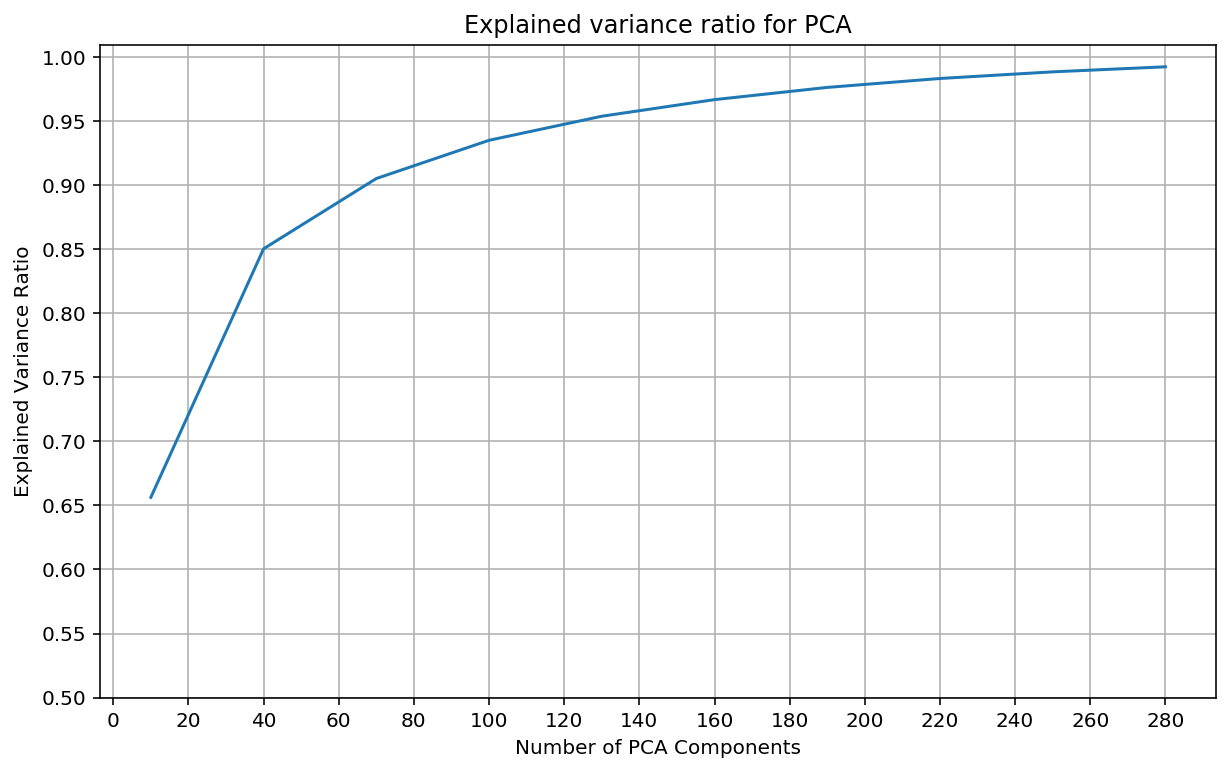

In [14]:
from sklearn.decomposition import PCA

candidate_components = range(10, 300, 30)
explained_ratios = []
for c in candidate_components:
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(X)
    explained_ratios.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.plot(candidate_components, explained_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance ratio for PCA')
plt.yticks(np.arange(0.5, 1.05, .05))
plt.xticks(np.arange(0, 300, 20))

当然是components越多还原率越高。但是超过95认为就差不多了。降维想要的就是维度越少越好。所以这里选择140。

### 分类
先分割数据集

In [27]:
X_train.shape

(320, 4096)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

X_train_pca = PCA(n_components=140).fit_transform(X_train)
X_test_pca = PCA(n_components=140).fit_transform(X_test)

ValueError: n_components=140 must be between 0 and min(n_samples, n_features)=80 with svd_solver='full'

SVM训练

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [1, 5, 10, 50, 100],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print(clf.best_params_, clf.best_score_)

# result
# {'C': 5, 'gamma': 0.005} 0.778125

{'C': 50, 'gamma': 0.001} 0.940625


In [19]:
clf.best_estimator_.score(X_test_pca, y_test)

NameError: name 'X_test_pca' is not defined